In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from molecular_dynamics import *

# 4. Molecular dynamics
_Kevin Vonk, s1706896, Apr 2020_

#### 1a)

Harmonic oscillators are partly characterised by their frequency. This frequency in turn dictates the time scale (or period) of the oscillation. This is given by
\begin{equation}
    T = 2\pi\sqrt{\frac{m}{k}}.
\end{equation}
Given that $m = k = 1$, this reduces to $T = 2\pi$.

Using trial and error, I determined that for a grid spacing of $\frac{T}{45}$ the variation in the energy deviation becomes smaller than the requested $5\cdot 10^{-3}$

The analytical solution for this simple harmonic oscillator is
\begin{equation}
    x(t) = A\cos{\left(\sqrt{\frac{k}{m}}t + \phi\right)}.
\end{equation}
We see that our computed result for the harmonic oscillator follows this general solution nicely. The initial conditions are random every run, so it becomes more difficult to compare the two in a plot directly. However, the initial conditions influence the amplitude and phase shift only.

A plot of the relevant energies in this system can also be found below

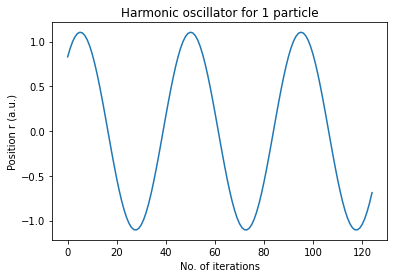

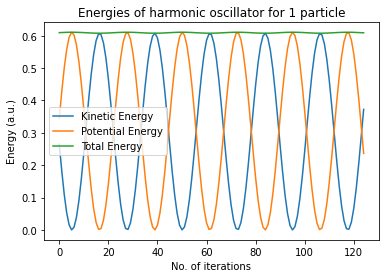

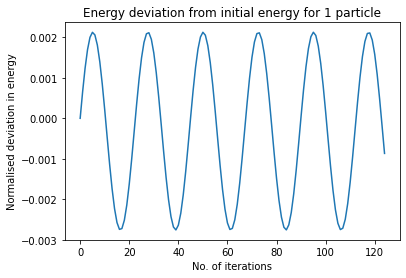

In [2]:
force = Force().spring_simple()
grid = Grid([Particle(np.random.rand(), np.random.rand())], 2*np.pi/45, force)

iter = 125

x = []
K = []
V = []

for i in range(iter):
    grid.update()
    x.append(grid[0].r)
    K.append(0.5*grid[0].v**2)
    V.append(0.5*grid[0].r**2)
    
E = np.array([k+v for k, v in zip(K,V)])

plt.plot(range(iter), x)
plt.xlabel("No. of iterations")
plt.ylabel("Position r (a.u.)")
plt.title("Harmonic oscillator for 1 particle")
plt.figure()
plt.plot(range(iter), K, label="Kinetic Energy")
plt.plot(range(iter), V, label="Potential Energy")
plt.plot(range(iter), E, label="Total Energy")
plt.xlabel("No. of iterations")
plt.ylabel("Energy (a.u.)")
plt.title("Energies of harmonic oscillator for 1 particle")
plt.legend()
plt.figure()
plt.plot(range(iter), (E - E[0]) / E[0])
plt.xlabel("No. of iterations")
plt.ylabel("Normalised deviation in energy")
plt.title("Energy deviation from initial energy for 1 particle");

#### 1b)

It seems from the results below that the step size $\frac{T}{45}$ is still accurate enough to be used. For the first run $x_0 = 1$ and $v_0 = 1$. The results for other values of $x_0$ and $v_0$ are given below.

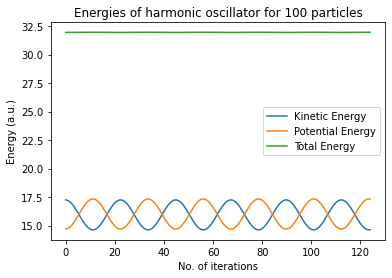

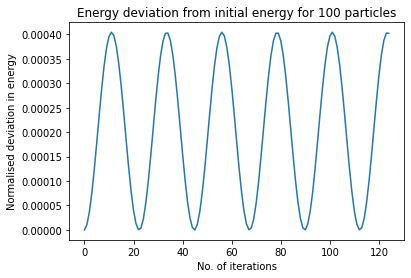

In [3]:
particles = ParticleManager().generate(N=100)
grid = Grid(particles, 2*np.pi/45, force)

K = []
V = []

for i in range(iter):
    grid.update()
    K.append(0.5*np.sum([p.v**2 for p in grid[:]]))
    V.append(0.5*np.sum([p.r**2 for p in grid[:]]))

E = np.array([k+v for k, v in zip(K,V)])
    
plt.plot(range(iter), K, label="Kinetic Energy")
plt.plot(range(iter), V, label="Potential Energy")
plt.plot(range(iter), E, label="Total Energy")
plt.xlabel("No. of iterations")
plt.ylabel("Energy (a.u.)")
plt.title("Energies of harmonic oscillator for 100 particles")
plt.legend()

plt.figure()
plt.plot(range(iter), (E - E[0]) / E[0])
plt.xlabel("No. of iterations")
plt.ylabel("Normalised deviation in energy")
plt.title("Energy deviation from initial energy for 100 particles");

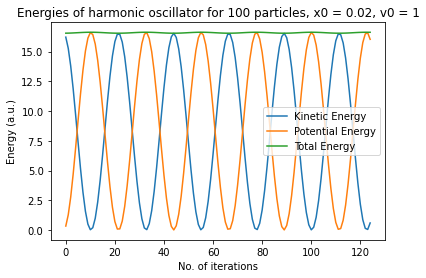

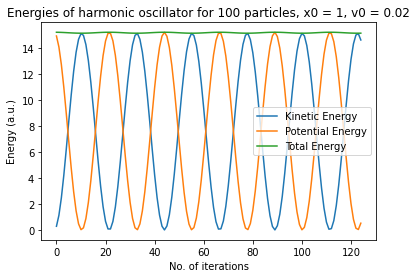

In [4]:
pool = ((1/50, 1), (1, 1/50))

for p in pool:
    particles = ParticleManager().generate(N=100, rlim=(-p[0], p[0]), vlim=(-p[1], p[1]))
    grid = Grid(particles, 2*np.pi/45, force)

    K = []
    V = []

    for i in range(iter):
        grid.update()
        K.append(0.5*np.sum([p.v**2 for p in grid[:]]))
        V.append(0.5*np.sum([p.r**2 for p in grid[:]]))

    E = np.array([k+v for k, v in zip(K,V)])
    
    plt.figure()
    plt.plot(range(iter), K, label="Kinetic Energy")
    plt.plot(range(iter), V, label="Potential Energy")
    plt.plot(range(iter), E, label="Total Energy")
    plt.xlabel("No. of iterations")
    plt.ylabel("Energy (a.u.)")
    plt.title(f"Energies of harmonic oscillator for 100 particles, x0 = {p[0]}, v0 = {p[1]}")
    plt.legend();

We can make some logical, but notable statements from these two plots. In the case where $x_0$ is small, the kinetic energy starts out large. This makes sense, since we have a lot of velocity. There is not a lot of gain to be made by moving towards the center of the well, since we are already so close to it.
In the other plot, the roles are reversed. We have plenty of energy to gain by moving towards the center of the well. Our velocity however is rather low, which is reflected by the kinetic energy.

The result which most closely mimics the equipartition of energy is when $x_0 = 1$ and $v_0 = 1$ (the first plot of 1b). In this case, both the kinetic and potential energy contribute roughly half towards the total energy. Additionaly, their variation is far more limited/constant compared to the other two scenarios.

#### 1c)

In order to implement the nearest neighbours interaction, we must obtain the force term out of the given total energy term. The force on the particles is deduced from the potential energy as follows.
\begin{equation}
    F = -\nabla V = -\nabla \frac{k}{2}\sum_i^N\left(x_{i+1}-x_{i}\right)^2.
\end{equation}
Considering the force $F$ on a particular particle $n$,
\begin{aligned}
    F_n &= -\frac{k}{2}\frac{\partial}{\partial x_n}\left(... + (x_n - x_{n-1})^2 + (x_{n+1} - x_n)^2 + ...\right) \\
    &= -k\left(\left(x_n - x_{n-1}\right) - \left(x_{n+1} - x_n\right)\right) \\
    &= -k\left(2x_n - x_{n-1} - x_{n+1}\right)
\end{aligned}

Running the script about 10 times, it looks like the $\frac{T}{45}$ grid spacing is still barely accurate enough. If I decrease it to $\frac{T}{100}$ however, the deviations in the total energy (which should be constant) decrease quite dramatically. Hence, I will use this grid spacing going forward.

Looking at the results found below, all three initial conditions move towards a state of equipartition of energy. It does seem that it takes a number of iterations before this state is reached. Taking about 50 iterations as an equilibrium time seems to ensure the system is in equilibrium every run.

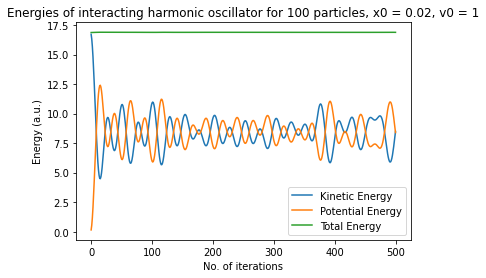

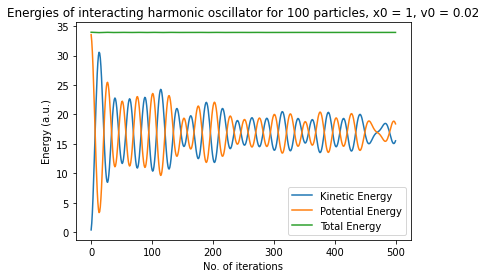

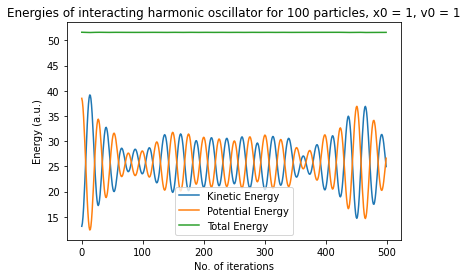

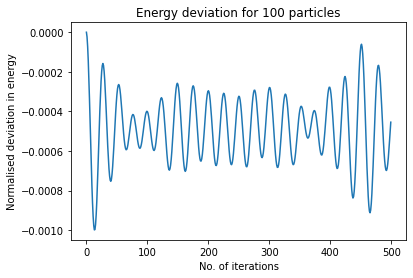

In [5]:
pool = ((1/50, 1), (1, 1/50), (1, 1))

iter = 500

for p in pool:
    particles = ParticleManager().generate(N=100, rlim=(-p[0], p[0]), vlim=(-p[1], p[1]), ret="self").remove_translation()
    force = Force().spring_nearest_neighbours()
    grid = Grid(particles, 2*np.pi/100, force)

    K = []
    V = []
    v = []

    for i in range(iter):
        grid.update()
        K.append(0.5*np.sum([p.v**2 for p in grid[:]]))
        V.append(0.5*np.sum([(grid[i+1].r - p.r)**2 for i, p in enumerate(grid[:])]))
        v.extend([p.v[0] for p in grid[:]])

    E = np.array([k+v for k, v in zip(K,V)])
    
    plt.figure()
    plt.plot(range(iter), K, label="Kinetic Energy")
    plt.plot(range(iter), V, label="Potential Energy")
    plt.plot(range(iter), E, label="Total Energy")
    plt.xlabel("No. of iterations")
    plt.ylabel("Energy (a.u.)")
    plt.title(f"Energies of interacting harmonic oscillator for 100 particles, x0 = {p[0]}, v0 = {p[1]}")
    plt.legend();

plt.figure()
plt.plot(range(iter), (E - E[0]) / E[0])
plt.xlabel("No. of iterations")
plt.ylabel("Normalised deviation in energy")
plt.title("Energy deviation for 100 particles");

In order to compute the instantaneous temperature, we will use the last run where $x_0 = 1$ and $v_0 = 1$. The first 50 iterations have been dropped to allow the system to find itself in equilibrium.

In [6]:
T = 2 / len(grid) * np.array(K[50:])
T_avg = np.mean(T)
print(f"The average temperature <T> = {T_avg} (a.u.)")

The average temperature <T> = 0.5145183229476881 (a.u.)


Lastly then, let us take a look at the distribution of velocities. The comparision to the Boltzmann distribution can be found below. The calculated average temperature is used for the Boltzmann distribution, as well as $k_B = 1$. Furthermore, the Boltzmann distribution has been renormalised based on the integral of itself, such that it more closely aligns with the computed velocity distribution.

What we can see from the figure below, is that the velocities present in the system after its initial equilibrium period closely follow the Boltzmann distribution.

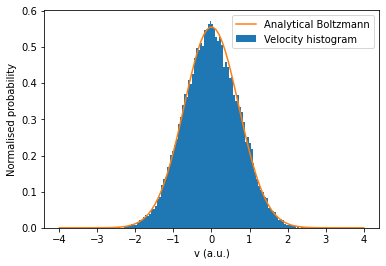

In [7]:
k = m = 1

e = lambda v: 0.5*m*v**2
v_ana = np.linspace(-4, 4, 100)
p_ana = np.exp(-e(v_ana) / (k*T_avg))

plt.hist(v[50*100:], bins=100, density=True, label="Velocity histogram")
plt.plot(v_ana, p_ana / np.trapz(p_ana, x=v_ana), label="Analytical Boltzmann")
plt.xlabel("v (a.u.)")
plt.ylabel("Normalised probability")
plt.legend();

#### 2a)

Utilising the definition of the Lennard-Jones pair potential, we are able to define a force $\vec{f_{ij}}$. This is the force exerted on a particle by the nearest other particle. Starting from the definition of the Lennard-Jones potential (and only considering the case where $r \leq R_c$),
\begin{aligned}
    \vec{f_{ij}} &= -\nabla_i u(r_{ij}) \\
    &= -\frac{\partial}{\partial r_{ij}}\left(4\epsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right]\right)\hat{r} \\
    &= -48\epsilon \frac{\sigma^{12}}{r_{ij}^{13}} + 24\epsilon \frac{\sigma^6}{r_{ij}^7} \\
    &=
    \begin{cases}
        \frac{24\epsilon}{r_{ij}}\left[\left(\frac{\sigma}{r_{ij}}\right)^6 - 2\left(\frac{\sigma}{r_{ij}}\right)^{12}\right]\hat{r} & r_{ij} \leq R_c \\
        0 & r_{ij} \gt R_c
    \end{cases}
\end{aligned}
Furthermore, $\vec{f_{ij}} = -\vec{f_{ji}}$. The force of particle i on particle j is exactly the same as the other way around, since they are at equal distance from another. Only the directionality changes, which is indicated by the minus.

In order to remove the dimensions from the problem, we start with the energy $E$.
\begin{equation}
    \tilde{E} = \frac{E}{\epsilon} = \frac{K}{\epsilon} + \frac{V}{\epsilon}.
\end{equation}
The kinetic energy can not be rewritten further. For the potential energy however, we can rewrite the Lennard-Jones potential as,
\begin{equation}
    \tilde{u}_{LJ}(\tilde{r}) = 4\left(\frac{1}{\tilde{r}^{12}} - \frac{1}{\tilde{r}^6}\right).
\end{equation}
This alteration of the Lennard-Jones potential also changes the exerted force $\vec{f_{ij}}$ too. Following the same derivation steps as above, we obtain (for the case where $\tilde{r_{ij}} \leq \tilde{R_c}$),
\begin{equation}
    \vec{\tilde{f_{ij}}} = \frac{24}{\tilde{r_{ij}}}\left(\frac{1}{\tilde{r}^6} - \frac{2}{\tilde{r}^{12}}\right)\hat{\tilde{r}}.
\end{equation}

For Argon gas, the temperature $T = 120K$ and the pressure $P = 4,16 \cdot 10^{7} N/m^2$.

#### 2b)

The useful property provided by the minimum image criterion is that when the distance $r$ to another particle becomes larger than $\frac{1}{2}L$, the same particle can be found at a closer distance in an imaged system. Or, because we will not be dealing with actual imaging programmatically, we can calculate where said image particle is supposed to be. This concept only works because of the periodic boundary conditions, which ensures a "wrap around".

The periodic boundary conditions also allow us to keep all the particles inside the $L\times L$ box. We can do this by using the modulo operator on the position after it has been updated.

#### 2c)

[5 5 5]


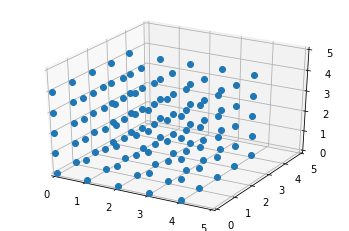

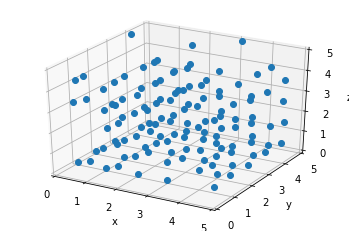

In [118]:
N = 125

particles = ParticleManager().generate_grid(N=N, rlim=(0, 5), ret="self").remove_translation(ret="self").scale(T=1)
force = Force().lennard_jones(rc = 2.5)
grid = Grid(particles, dt=0.004, force=force)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d((0,5))
ax.set_ylim3d((0,5))
ax.set_zlim3d((0,5))
scatter, = ax.plot([p.r[0] for p in grid[:]], [p.r[1] for p in grid[:]], [p.r[2] for p in grid[:]], marker="o", linestyle="")

for _ in range(100):
    grid.update()

handle = grid.animate((0, 5))
HTML(handle.to_html5_video())